# Interpolation Part 4: Spline interpolation

## A brief return to linear interpolation: basis functions.

In part 2 of this chapter we considered piecewise linear interpolation; given a set of $n$ data points $(x_k,y_k),$ $k=0,1,...,n-1$ that partition $x\in[a,b]$ into subintervals $[x_k,x_{l+1}]$ where 

$$
a=x_0 < x_1<x2<...<x_{n-1}=b, 
$$

the interpolant for $x\in[x_k,x_{k+1}]$ will be

$$p_{1k}(x) = \frac{x-x_{k+1}}{x_k-x_{k+1}}y_k + \frac{x-x_k}{x_{k+1}-x_k}y_{k+1}.$$

The complete piecewise linear function is

$$S_1(x) = \sum\limits_{k=0}^{n-1}p_{1k}(x).$$
Alternatively, this can be rewritten as

$$S_1(x)=\sum_{k=0}^{n}f(x_k)\phi_k(x)\,,$$

where the *basis functions* $\phi_k$ are defined as

$$\phi_k(x)= \begin{cases} \frac{x-x_{k+1}}{x_{k}-x_{k+1}} & \;\; x_{k} \le x \le  x_{k+1}\\ 
\frac{x-x_{k-1}}{x_{k}-x_{k-1}} & \;\;  x_{k-1} \le x \le  x_{k}\\
0 & \;\; \textrm{elsewhere}.\end{cases}$$

These basis functions are *hat* or *tent* functions:


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})            # Increase the font size to 14pt

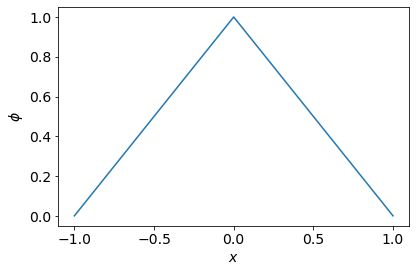

In [14]:
# define the hat given the points -1,0,1
x0 = -1
x1 = 0
x2 = 1

def phi(x):
    y = np.zeros_like(x)
    ir = np.where((x1<x[:]) & (x[:]<=x2))
    il = np.where((x0<x[:]) & (x[:]<=x1))
    y[il[:]] = (x[il[:]]-x0)/(x1-x0)
    y[ir[:]] = (x[ir[:]]-x2)/(x1-x2)
    return y

x = np.linspace(-1,1,51)
y = phi(x)

plt.figure(figsize=(6,4))
plt.plot(x,y)
plt.xlabel('$x$')
plt.ylabel('$\phi$')
plt.tight_layout()
plt.show()

Notice that 

$$\phi_k(x_{k-1})=0\;,\quad\phi_k(x_{k})=1\quad{\rm and}\quad\phi_k(x_{k+1})=0\;.$$

and $S_1(x)$ is constrained to be continuous but may have discontinuities in $S_1'(x).$

This is an example of a **spline**. The piecewise polynomials we constructed in the previous notebook are a generalisation of this idea of splines. While we saw that they provide an improvement for *Runge's phenomenon*, the lack of smoothness due to potential discontinuities in the derivatives at the knots can create significant errors, as we will see.

## Splines: General Definition

In general, such a piecewise function forming a spline of degree $m$, $S_m$ say, is defined as follows:

Let $[a,b]$ be partitioned into sub-intervals $[x_{k-1},x_k]$, $1 \le k \le n$, where $a=x_0 < x_1 < \dots < x_n=b\,$. A spline $S_m$ of degree $m$ in $[a,b]$ satisfies the following properties:

$\hspace{.5cm}$ (i) $S_m \in P_m\,$: $S_m$ restricted to $[x_{k-1},x_k]$ is a polynomial of degree at most $m \ge 1$.

$\hspace{.5cm}$ (ii) $S_m \in C^{m-1}[a,b]\,$: the $(m-1)$th derivatives are continuous.

Thus, for a given partition of $[a,b]$, the spline consists of $n$ $m$-degree polynomial segments with the appropriate continuity condition at each of the interior knots. This will ensure that the spline has a certain degree of *smoothness*.

## Cubic Splines

We consider the most commonly used spline, *the cubic spline*, when $m=3$.

Given $(n+1)$ points, $x_0,x_1,\dots,x_n$, which are equally spaced, we wish to construct a piecewise cubic $S_3(x)$ such that 

$$S_3(x_k) = f(x_k), \qquad k=0,1,\dots,n\,,$$

and

$$ S_3(x) \in C^2[x_0,x_n]\,,$$

i.e. $S_3(x)$ is continuous and has continuous 1st and 2nd derivatives for $ x_0 < x < x_n$ (at the interior knots).

**Can this be done??**

A typical cubic has 4 unknowns ($ax^3+bx^2+cx+d$). We have $n$ intervals so there are $n$ cubics to be constructed, i.e. $4n$ <u>unknowns</u>.


When fitting the data points, there are 2 values of $f(x)$ for each sub-interval, and $n$ intervals, so a total of $2n$ <u>conditions</u>.
 
There are $(n-1)$ interval data points, $x_1,x_2,\dots,x_{n-1}$, so to ensure that $S'(x)$ is continuous we have $(n-1)$ <u>conditions</u>.

Likewise, to ensure $S''(x)$ is continuous we have a further $(n-1)$ <u>conditions</u>.

Hence, a total number of $4n-2$ <u>conditions</u>. We are 2 short!

The two further conditions can be found in several ways:

* <u>Case (i):</u> If we know $f'(x_0)$ and $f'(x_n)$ we could use these to provide 2 further conditions.

* <u>Case (ii):</u> We could estimate $f'(x_0)$ and $f'(x_n)$ from the values of $f(x_k)$ and use these estimates.

* <u>Case (iii):</u> We could impose the condition that $S''(x_0) \equiv 0$ and $S''(x_n) \equiv 0$. A spline constructed in this way is called a *natural spline*.


**How do we construct $S_3(x)$?** 

With $n$ cubics, $4n$ unknowns and $4n$ equations, the whole exercise looks horrendous!

One of the easiest ways to do this is to define a basis for the cubic spline similar to the basis of the linear spline.

### The basis approach

Given a set of $(n+1)$ uniformly spaced data points ($n$ equal sub-intervals), then a cubic spline is given by

$$
S_3(x)=\sum_{k=-1}^{n+1}a_kB_k(x)\,,$$

where $B_k(x)$ is the *basis* of the cubic spline. 

Let the $(n+1)$ knots be $x_0,x_1,\dots,x_n$ and assume that these knots are uniformly spaced at intervals of $h=1$ with $x_0=0$, for simplicity (this assumption will be relaxed later so we can consider more general cases). Thus, $x_k = k$.

**The Cubic B-Spline ${B_0(x)}$** is defined as:


\begin{align*}
B_0(x) & = 0, \qquad x \le -2 \,, \\
B_0(x) & = \frac{1}{6}(2+x)^3, \qquad -2 \le x \le -1 \,,\\
B_0(x) & = \frac{2}{3}-\frac{1}{2}x^2(2+x),\qquad -1 \le x \le 0 \,,\\
B_0(x) & = \frac{2}{3}-\frac{1}{2}x^2(2-x),\qquad 0 \le x \le 1 \,,\\
B_0(x) & = \frac{1}{6}(2-x)^3, \qquad 1 \le x \le 2 \,,\\
B_0(x) & = 0, \qquad x \ge 2 \,,
\end{align*}

Note, that at the knots $x_k = 0,\;\pm 1$ and $\pm 2$

 $$
 B_0(0)=\frac{2}{3}, \;\; B_0(\pm 1)=\frac{1}{6}, \;\; B_0(\pm2)=0\,.
 $$ 
 
$$
B'_0(0)=0, \;\; B'_0(\pm 1)=\mp\frac{1}{2}, \;\; B'_0(\pm2)=0\,.
$$ 

$$
B''_0(0)=-2, \;\; B''_0(\pm 1)= 1, \;\; B''_0(\pm2)=0\,.
$$ 

$B_0(x)$ is an example of a cubic spline. It is simple to show that $B'_0(x)$ and $B''_0(x)$ are continuous.

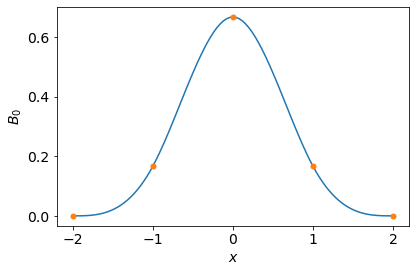

In [16]:
# define the B given the points -1,-2,0,1,2
x0 = -2.
x1 = -1.
x2 = 0.
x3 = 1.
x4 = 2.

def phi(x):
    y = np.zeros(len(x))#np.zeros_like(x)
    i1 = np.where((x0<x[:]) & (x[:]<=x1))[0]
    i2 = np.where((x1<x[:]) & (x[:]<=x2))[0]
    i3 = np.where((x2<x[:]) & (x[:]<=x3))[0]
    i4 = np.where((x3<x[:]) & (x[:]<=x4))[0]
    y[i1[:]] = (2+x[i1[:]])**3/6.
    y[i2[:]] = 2./3.-0.5*x[i2[:]]**2*(2+x[i2[:]])
    y[i3[:]] = 2./3.-0.5*x[i3[:]]**2*(2-x[i3[:]])
    y[i4[:]] = (2-x[i4[:]])**3/6.
    return y

knots = np.array([x0,x1,x2,x3,x4])


x = np.linspace(-2,2,101)
y = phi(x)

plt.figure(figsize=(6,4))
plt.plot(x,y)
plt.plot(knots,phi(knots),'.',ms=10)
plt.xlabel('$x$')
plt.ylabel('$B_0$')
plt.tight_layout()
plt.show()

In general, $B_k(x)$ is defined as $B_0(x-k)$.

A linear combination of such functions will be continuous on $C^2[0,1]$, so they will automatically fulfill $(n-1)\times 3 = 3n -3$ of the $4n$ conditions. Hence, another $4n-(3n-3)=n+3$ conditions are required.

Now consider the function $S_3(x)$ on the points, $0,1,\dots,n$,

$$
S_3(x)=\sum_{k=-1}^{n+1} a_k B_k(x)\,, \qquad(1)
$$

which represents a linear combination of $(n+3)$ functions with the prescribed continuities.

* Consider an interval, $[0,1]$ say, this interval has contributions from 4 basis functions $B_{-1},\, B_0,\, B_1,\, B_2$

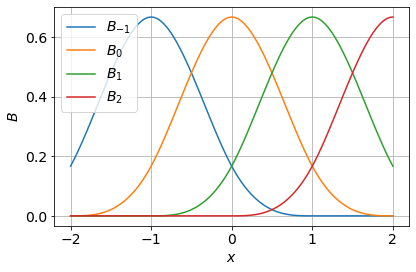

In [4]:
x = np.linspace(-2,2,101)

plt.figure(figsize=(6,4))
plt.plot(x,phi(x+1),label='$B_{-1}$')
plt.plot(x,phi(x),label='$B_0$')
plt.plot(x,phi(x-1),label='$B_1$')
plt.plot(x,phi(x-2),label='$B_2$')
plt.xlabel('$x$')
plt.ylabel('$B$')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

Similarly, the general interval $[x_i,x_{i+1}]$ has non-zero contributions from $B_{i-1}$, $B_{i}$, $B_{i+1}$ and $B_{i+2}$, thus

\begin{align*}
S_3(x) & = a_{k-1}B_{k-1}(x)+a_{k}B_{k}(x)+a_{k+1}B_{k+1}(x)+a_{k+2}B_{k+2}(x)\\& =a_{k-1}B_{0}(x-k+1)+a_{k}B_{0}(x-k)+a_{k+1}B_{0}(x-k-1)+a_{k+2}B_{0}(x-k-2)\,.
\end{align*}
At the knots, $x_k=k$, our cubic spline must equal the values $f(x_k)$. Hence, we require

$$
S_3(x_k)=f(x_k)=f(k)\,.
$$

So,

$$
S_3(k)=a_{k-1}B_{0}(1)+a_{k}B_{0}(0)+a_{k+1}B_{0}(-1)+a_{k+2}B_{0}(-2)
 = f(k)=f(x_k)\,,
$$

which gives

$$
f(x_k)=f(k)=\frac{1}{6}a_{k-1}+\frac{2}{3}a_{k}+\frac{1}{6}a_{k+1}+0\,,
$$

and thus,

$$
a_{k+1}+4a_{k}+a_{k-1}=6f(x_k),\qquad x_k=k\,.
$$

We have $(n+3)$ unknowns, $a_{-1},a_{0},\dots,a_{n+1}$ and $(n+1)$ data points $\left(x_k,f(x_k)\right)$, $k=0,1,\dots,n$.

Thus, we require <u>2 extra conditions</u> to find all $a_k$'s.

Suppose we insist that $S''_3(0)=0$ as one extra condition:

$$
(k=0) \qquad a_{-1}B''_{-1}(0)+a_{0}B''_{0}(0)+a_{1}B''_{1}(0)+a_{2}B''_{2}(0)=0\,,
$$

and hence,

$$ a_{-1}B''_{0}(1)+a_{0}B''_{0}(0)+a_{1}B''_{0}(-1)+a_{2}B''_{0}(-2)=0\,,$$
    
or,

$$ a_{-1}\times(1) + a_{0}\times(-2)+ a_{1}\times(1) + 0 =0\,,$$

so 

$$
    a_{-1}=2a_{0}-a_{1}\,,$$

and,

$$a_{-1}+4a_{0}+a_{1}=6f(x_0)=6f(0)\,,$$

so
    
$$
6a_0=6f(0)\,.
$$
    
We can produce a similar equation by requiring that 

$$ S''_3(n)=0\,,$$

which gives us

$$ a_{n-1}-2a_{n}+a_{n+1}=0\quad\Rightarrow\quad a_{n+1}=2a_{n}-a_{n-1}\,,$$
    
and hence,

$$ 6a_n=6f(n)\,.$$
    
For a <u>natural spline</u> we have the following system of equations
    
\begin{align*}
& a_0=f(0) \\
& a_0 + 4 a_1 + a_2 = 6 f(1) \\
& \dots \\
& a_{n-2} + 4 a_{n-1} + a_n = 6 f(n-1) \\
& a_n = f(n)\,.
\end{align*}

Or, in matrix form:

\begin{align*}
\begin{bmatrix} 
1      & 0 & 0     & \dots &   & \dots & 0      \\ 
1      & 4 & 1     & 0     &   & \dots & \vdots \\
0      & 1 & 4     & 1     & 0 & \dots & 0      \\
\vdots &   &       &       &   &       & \vdots \\
\vdots &   & \dots & 0     & 1 & 4     & 1      \\
0      &   & \dots &       & 0 & 0     & 1   
\end{bmatrix}
\begin{bmatrix}
a_0 \\
a_1 \\
\vdots \\
\vdots \\
a_{n-1} \\
a_n
\end{bmatrix}
=
\begin{bmatrix}
f(0) \\
6 f(1)\\
\vdots \\
\vdots \\
6 f(n-1) \\
f(n)
\end{bmatrix}
\end{align*}
    
This is a linear system of $(n+1)$ equations which we can solve to find the $(n+1)$ unknowns $a_k$, $k=0,\dots,n$. The constants $a_{-1}$ and $a_{n+1}$ can then be found ($a_{-1}=2a_{0}-a_{1}$ and $a_{n+1}=2a_{n}-a_{n-1}$). 

Finally, once we know all the $a_k$, the full spline $S_3(x)$ can be obtained from equation (1).

### General Cubic Spline

In the previous section, we considered the cubic spline fitted to a set of $n+1$ data points uniformly distributed on $[0,n]$ i.e. the data points had an interval of 1 such that $x_k=k$, $k=0,\dots,n$. However, in general, data points are unlikely to be spaced in such a manner.

Cubic splines are relatively simple on uniformly spaced data points and so we consider the case of $n+1$ data points uniformally spaced with an interval of $h$ over the range $[a,b]$. Hence $x_k = a+kh$ and $h = (b-a)/n$

The basis for the cubic B-Spline then becomes

\begin{align*}
B_0(x) & = 0, \qquad x-a \le -2h \,, \\
B_0(x) & = \frac{1}{6}(2h+(x-a))^3, \qquad -2h \le x-a \le -h \,,\\
B_0(x) & = \frac{2h^3}{3}-\frac{1}{2}(x-a)^2(2h+(x-a)),\qquad -h \le x-a \le 0 \,,\\
B_0(x) & = \frac{2h^3}{3}-\frac{1}{2}(x-a)^2(2h-(x-a)),\qquad 0 \le x-a \le h \,,\\
B_0(x) & = \frac{1}{6}(2h-(x-a))^3, \qquad h \le x-a \le 2h \,,\\
B_0(x) & = 0, \qquad x-a \ge 2h \,,
\end{align*}

The overall cubic spline is still equal to $$S_3(x)=\sum_{k=-1}^{n+1} a_k B_k(x)\,,$$ 
with $B_k(x) = B_0(x-kh)$ and the $a_k\;,$ $k=-1,\dots,n+1$ given by  
\begin{align*}
& a_0= \frac{1}{h^3}f(x_0) \\
& a_0 + 4 a_1 + a_2 = \frac{6}{h^3} f(x_1) \\
& \dots \\
& a_{n-2} + 4 a_{n-1} + a_n = \frac{6}{h^3} f(x_{n-1}) \\
& a_n = \frac{1}{h^3} f(x_n)\,.
\end{align*}
with, in the natural spline case, 
$$a_{-1}=2a_{0}-a_{1}\quad{\rm and}\quad a_{n+1}=2a_{n}-a_{n-1}\,.$$
    
### Application
    
Arguably the structure of the B-spline code with basis functions is a little more obvious than the piecewise polynomial code from the previous notebook. The implementation requires:
    
* A function defining the basis functions $B_k,$
    
* Setting up the tridiagonal matrix and right hand side vector, given the number of knots $n+1.$
    
* Solving this linear system to obtain $a_0,\,a_1,\,\dots,\,a_n,$

* Compute $a_{-1}$ and $a_{n+1},$
    
* For each new evaluation point sum the contributions from each of the four $B_k$ basis functions which have the point inside of their support,
    
* DONE!
    
Below we show this implemented and demonstrate its advantage over the regular piecewise cubic interpolation for the Runge's function example of the previous notebook.

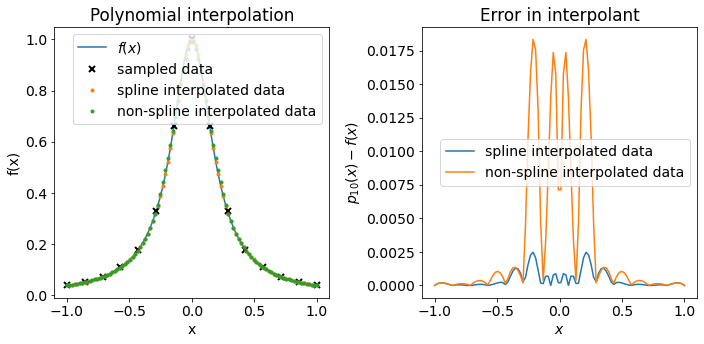

In [17]:
# Set the basis function, B_k(x)
def Bspl(x,x0,k):
    h = x0[1]-x0[0]         # assumes evenly spaced data
    xx = x-x0[0]-k*h        # following the formulae above set xx = x-xk = x-a-kh
    if(xx<-2*h or xx>2*h):
        return 0
    elif(xx>=-2*h and xx<=-h):
        return (2*h+xx)**3/6.
    elif(xx>-h and xx<=0):
        return 2*h**3/3 - 0.5*xx**2*(2*h+xx)
    elif(xx>0 and xx<=h):
        return 2*h**3/3 - 0.5*xx**2*(2*h-xx)
    elif(xx>=h and xx<=2*h):
        return (2*h-xx)**3/6.

def f(x): # Runge's function for testing
    return 1/(1+25*x**2)
    
# Interval of interest
a = -1
b = 1

# set the knots
M = 15
x0 = np.linspace(a,b,M)
y0 = f(x0)

# get the knot spacing
h = x0[2]-x0[1]

# set the new evaluation points
N = 100
x = np.linspace(a,b,N)

#----------------------------------------------------------------
# No loops are required here but we need to set up the matrix A:

ik = np.arange(M)            # use this array of integers to set diagonals
matA = 4*np.eye(M)           # set up matrix as 4*identity and then...
matA[ik[1:M],ik[1:M]-1] = 1  # set lower diagonal
matA[ik[1:M]-1,ik[1:M]] = 1  # set upper diagonal 

# First and last rows for natural spline
matA[0,:] = 0                
matA[-1,:] = 0
matA[0,0] = 1
matA[-1,-1] = 1


vecb = np.zeros(M) # set up RHS vector b
vecb[:] = y0[:]/h**3
vecb[1:-1] *= 6.0       # first entry

#----------------------------------------------------------------
# Now we can solve the system Ax=b using numpy:

a = np.linalg.solve(matA,vecb)  
a = np.insert(a,0,2*a[0]-a[1])     # insert the -1 coefficient
a = np.insert(a,M+1,2*a[M]-a[M-1]) # insert the n+1 coefficient


ff = np.zeros(N)
for i in range(N):                 # Loop the new points
    jj = int((x[i]-x0[0])/h)       # Find the subinterval k
    if(x[i]==x0[jj]):              # If evaluation point is a knot...
        ff[i] = y0[jj]             # use the knot
        continue
    for j in range(-1,3):          # Loop the 4 basis functions
        k = jj+j
        ff[i] += a[k+1]*Bspl(x[i],x0,k)   # accumulate contributions
        

# Do piecewise (non-Spline) interpolation for comparison
#------------------------------------------------------------
# Code from previous notebook
Ndeg = 3
nPoly = M - Ndeg
pts = np.arange(Ndeg+1) + np.arange(nPoly).reshape(nPoly,1) 
a = np.zeros((Ndeg+1,nPoly))

for i in range(nPoly): # for each poly solve the vandermode system
    A = np.vander(x0[pts[i,:]])
    a[:,i] = np.linalg.solve(A,y0[pts[i,:]])

pows = (Ndeg-np.arange(Ndeg+1))
y = np.empty_like(x)

for i in range(N): # loop over the new points 

    if((x[i]<x0).all()):
        k = 0
    elif((x[i]>x0).all()):
        k = M-1
    else:
        k = np.where(((x[i]<x0[1:]) & (x[i]>=x0[:-1])) | ((x0[1:]==x[i]) & (x[i]>x0[:-1])))[0][0]

    j = k - Ndeg//2     
    j = max(0,j)
    j = min(j,nPoly-1)
    
    y[i] = np.sum(a[:,j]*x[i]**pows)
        
fig = plt.figure(figsize=(10,5))  # Make the plot bigger than default to stop things getting cramped

ax1 = fig.add_subplot(121)        # 1 row, 2 columns, first plot

# same plot as before, some options are a bit different
#------------------------------------------------------------
ax1.plot(x,f(x),label=r'$f(x)$')           
ax1.plot(x0,y0,'kx',mew=2,label='sampled data')
ax1.plot(x,ff,'.',label='spline interpolated data')
ax1.plot(x,y,'.',label='non-spline interpolated data')
ax1.set_xlabel('x') # now we use the "ax.set_ " version of the commands
ax1.set_ylabel('f(x)')
ax1.legend()
ax1.set_title('Polynomial interpolation')
#------------------------------------------------------------

ax2 = fig.add_subplot(122) # 1 row, 2 columns, first plot

# similar plots as before, some options are a bit different
#------------------------------------------------------------
ax2.plot(x,np.abs(ff-f(x)),label='spline interpolated data')   
ax2.plot(x,np.abs(y-f(x)),label='non-spline interpolated data')   
ax2.set_xlabel('$x$') # now we use the "ax.set_ " version of the commands
ax2.set_ylabel(r'$p_{10}(x)-f(x)$')
ax2.set_title('Error in interpolant')
ax2.legend()
#------------------------------------------------------------

fig.tight_layout() # this spaces the plots nicely


#### `scipy` implementation

As with many examples in numerical analysis, common methods like cubic splines are implemented in common Python modules. In this case the `scipy.interpolate` module has the function `CubicSpline` which takes the knots, the boundary condition (e.g. *natural*), and returns the cubic spline function.

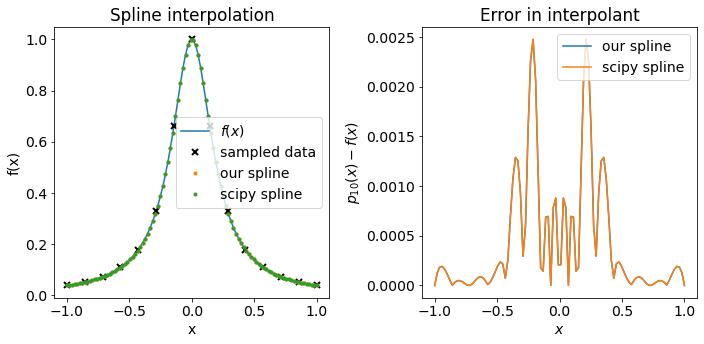

In [6]:
from scipy.interpolate import CubicSpline

cs = CubicSpline(x0, y0,bc_type='natural')

fig = plt.figure(figsize=(10,5))  # Make the plot bigger than default to stop things getting cramped

ax1 = fig.add_subplot(121)        # 1 row, 2 columns, first plot

# same plot as before, some options are a bit different
#------------------------------------------------------------
ax1.plot(x,f(x),label=r'$f(x)$')           
ax1.plot(x0,y0,'kx',mew=2,label='sampled data')
ax1.plot(x,ff,'.',label='our spline')
ax1.plot(x,cs(x),'.',label='scipy spline')
ax1.set_xlabel('x') # now we use the "ax.set_ " version of the commands
ax1.set_ylabel('f(x)')
ax1.legend()
ax1.set_title('Spline interpolation')
#------------------------------------------------------------

ax2 = fig.add_subplot(122) # 1 row, 2 columns, first plot

# similar plots as before, some options are a bit different
#------------------------------------------------------------
ax2.plot(x,np.abs(ff-f(x)),label='our spline')   
ax2.plot(x,np.abs(cs(x)-f(x)),label='scipy spline')   
ax2.set_xlabel('$x$') # now we use the "ax.set_ " version of the commands
ax2.set_ylabel(r'$p_{10}(x)-f(x)$')
ax2.set_title('Error in interpolant')
ax2.legend()
#------------------------------------------------------------

fig.tight_layout() # this spaces the plots nicely


Our implementation looks virtually identical to scipy, reassuring that we have the method correct. It is likely, however, that the `scipy` version is better optimised than ours so is usually preferrable. It is not uncommon, however, for use cases to exist for which built in functions are not suited, so being able to build our own gives us a lot more flexibility.

Just to check, we can calculate the difference between our implementation and the `scipy` version

In [7]:
np.max(np.abs(cs(x)-ff))


3.3306690738754696e-15

It is close to machine precision which indicates to us the only difference is floating point errors, likely due to the order of operations.